In [1]:
import re 
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from nltk.corpus import stopwords
from collections import Counter
from PIL import Image
from nltk.stem.wordnet import WordNetLemmatizer
from yellowbrick.text.freqdist import FreqDistVisualizer
from yellowbrick.style import set_palette


import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('CSV_Final_negative_sf.csv')

## NLTK Stop words

In [3]:

stop_words = stopwords.words('english')

#stop_words.extend([])

In [4]:
type(stop_words)

list

## Vectorizing & Document Matrix

In [5]:
vectorizer = CountVectorizer(stop_words='english')

docs = vectorizer.fit_transform(df.comments)

features = vectorizer.get_feature_names()


In [65]:
vectorizer2 = CountVectorizer(stop_words='english')

docs2 = vectorizer2.fit_transform(df.comments)

features = vectorizer2.get_feature_names()

In [ ]:

tf = TfidfVectorizer(stop_words=stopwords, min_df = 2, max_df=0.7)

docs = tf.fit_transform(df['comments'])

features = tf.get_feature_names()

## Read samples of reviews

In [6]:
for sample in df['spacy_doc'].sample(5).values:
    print(sample)
    print()

Don’t come

Donna's flat is exactly as described. We wish we could have stayed longer. Parking was a bit more difficult than we expected but we found a spot a block away. The location can't be beat. And there is a small grocery shop a few blocks away to pick up anything you need.

The host canceled this reservation 5 days before arrival. This is an automated posting.

It s a share house no privacy 

It was my fault overlooking the size of the bed - it was too small for my 6'4'' tall boyfriend. The location was great - but was loud, hearing people screaming in the middle of the night.  It was not a surprise as it is right in the downtown SF (and I used to live in SF for many many years) but thought that I'd mention it in case you are looking for more quiet space.



In [7]:
for sample in df['comments'].sample(5).values:
    print(sample)
    print()

The host canceled this reservation 47 days before arrival. This is an automated posting.

The host canceled this reservation 40 days before arrival. This is an automated posting.

It can get hot in the room during summer months. They have no air conditioning or ceiling fans in the rooms. They told us that they have portable fans available, but when we asked for one day they had all  run out.

The Green Tortoise is rad hostel

recommended



## Most Used Words

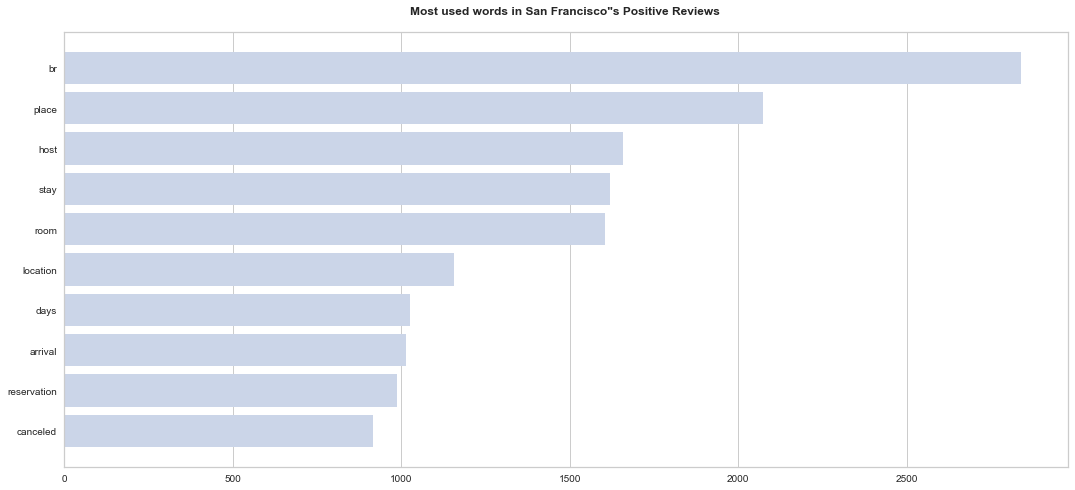

In [8]:
set_palette('pastel')
plt.figure(figsize=(18,8))
plt.title('Most used words in San Francisco"s Positive Reviews \n', fontweight='bold')

##yellowbrick
vis = FreqDistVisualizer(features=features, n = 10)
vis.fit(docs)
vis.poof;

## Creating World Cloud words

In [9]:
def wordcloud_words(wordcloud):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(' San Francisco Negative Reviews\n', fontsize=18, fontweight='bold')
    plt.savefig('SFNegativeReviews')
    plt.show()

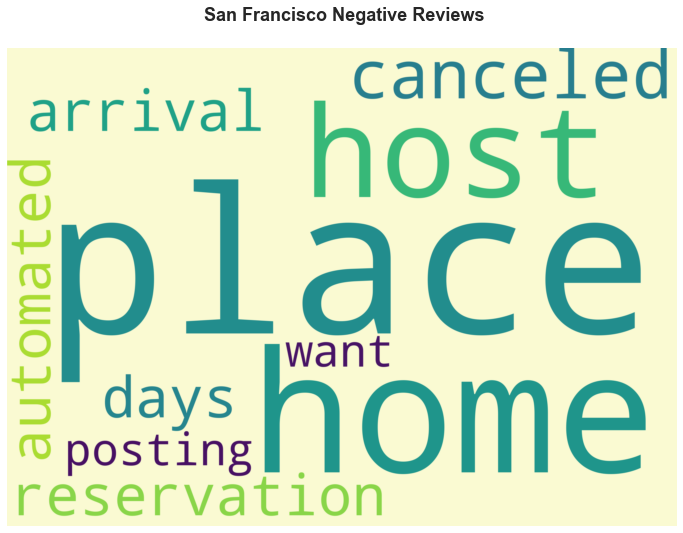

In [10]:
posWords = WordCloud(max_font_size=None, max_words = 10, background_color="lightgoldenrodyellow", 
                      width=3500, height=2500,
                      stopwords=stopwords.words('english')).generate(str(df.comments.values))

wordcloud_words(posWords)

## Simple Additional Cleaning

In [11]:
def clean(sents):
    for word in sents:
        word = re.sub('\s+', ' ', word)  
        word = re.sub("\'", "", word)  
        word = gensim.utils.simple_preprocess(str(word), deacc=True) 
        yield(word)  


# Apply cleaning

In [12]:
all_data = df.comments.values.tolist()
clean_sent = list(clean(all_data))
print(clean_sent[:1])

[['the', 'host', 'canceled', 'this', 'reservation', 'days', 'before', 'arrival', 'this', 'is', 'an', 'automated', 'posting']]


In [13]:
print(clean_sent[:5])

[['the', 'host', 'canceled', 'this', 'reservation', 'days', 'before', 'arrival', 'this', 'is', 'an', 'automated', 'posting'], [], ['if', 'you', 'want', 'to', 'fell', 'the', 'concept', 'being', 'home', 'away', 'of', 'home', 'stay', 'at', 'holly', 'place', 'really', 'wonder', 'full', 'place', 'and', 'she', 'is', 'an', 'excelent', 'hostess'], ['on', 'very', 'quiet', 'residential', 'street', 'but', 'close', 'to', 'transportation', 'holly', 'responded', 'to', 'texts', 'immediately', 'would', 'return'], []]


## Bigram & Trigram

In [14]:

bi_gram = gensim.models.Phrases(clean_sent, min_count=5, threshold=100) 

tri_gram = gensim.models.Phrases(bi_gram[clean_sent], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bi_gram)

trigram_mod = gensim.models.phrases.Phraser(tri_gram)

## Clean, Remove & Lemma

In [15]:

def cleaning(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
       
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    
    nlp = spacy.load("en_core_web_sm")
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])     
    
    clean_text = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    
    return clean_text


## Apply final cleaning on prev cleaned list

In [16]:
doc_clean = cleaning(clean_sent)
doc_clean[:5]

[['host', 'cancel', 'reservation', 'day', 'arrival', 'automated_poste'],
 [],
 ['fall',
  'concept',
  'home',
  'away',
  'home',
  'stay',
  'holly',
  'place',
  'really',
  'wonder',
  'full',
  'place',
  'excelent',
  'hostess'],
 ['quiet',
  'residential',
  'street',
  'close',
  'transportation',
  'holly',
  'respond',
  'text',
  'immediately',
  'return'],
 []]

## Create Dictionary & Corpus

In [17]:
doc_dict = corpora.Dictionary(doc_clean)

corpus = [doc_dict.doc2bow(text) for text in doc_clean]


## Build The LDA model

In [18]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=doc_dict,num_topics=8, random_state=33,
                                           update_every=1,chunksize=15,passes=10,alpha='symmetric',iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.162*"host" + 0.129*"reservation" + 0.112*"cancel" + 0.082*"day" + '
  '0.076*"arrival" + 0.039*"automated_poste" + 0.005*"worst" + 0.003*"skill" + '
  '0.002*"co" + 0.002*"top_notch"'),
 (1,
  '0.048*"host" + 0.046*"clean" + 0.031*"pay" + 0.030*"door" + 0.028*"use" + '
  '0.022*"expect" + 0.018*"book" + 0.017*"try" + 0.016*"recommend" + '
  '0.015*"bedroom"'),
 (2,
  '0.099*"parking" + 0.093*"br" + 0.068*"location" + 0.055*"great" + '
  '0.046*"street" + 0.036*"car" + 0.028*"close" + 0.027*"park" + 0.021*"city" '
  '+ 0.019*"right"'),
 (3,
  '0.089*"room" + 0.038*"get" + 0.035*"night" + 0.027*"bed" + 0.023*"check" + '
  '0.021*"hotel" + 0.020*"need" + 0.020*"come" + 0.017*"apartment" + '
  '0.017*"people"'),
 (4,
  '0.063*"also" + 0.040*"leave" + 0.038*"dirty" + 0.027*"smell" + '
  '0.018*"towel" + 0.017*"sheet" + 0.015*"stain" + 0.014*"luggage" + '
  '0.013*"food" + 0.013*"easy"'),
 (5,
  '0.042*"even" + 0.038*"area" + 0.037*"airbnb" + 0.036*"feel" + 0.035*"find" '
  '+ 0.03

## List of words by topic

In [20]:
topics = lda_model.show_topics(formatted=False)

In [21]:
type(topics)

list

In [20]:
topics

[(0,
  [('host', 0.16204326),
   ('reservation', 0.12909532),
   ('cancel', 0.11168089),
   ('day', 0.08201311),
   ('arrival', 0.07569694),
   ('automated_poste', 0.038559567),
   ('worst', 0.005397238),
   ('skill', 0.0034300438),
   ('co', 0.0024134156),
   ('top_notch', 0.0021486178)]),
 (1,
  [('host', 0.04784045),
   ('clean', 0.04626172),
   ('pay', 0.030701572),
   ('door', 0.030147705),
   ('use', 0.027690733),
   ('expect', 0.022304628),
   ('book', 0.018370189),
   ('try', 0.017267846),
   ('recommend', 0.015954522),
   ('bedroom', 0.015429997)]),
 (2,
  [('parking', 0.09863375),
   ('br', 0.09345059),
   ('location', 0.06838153),
   ('great', 0.05475998),
   ('street', 0.045963287),
   ('car', 0.03618653),
   ('close', 0.027934855),
   ('park', 0.027303435),
   ('city', 0.021326484),
   ('right', 0.019034157)]),
 (3,
  [('room', 0.08865171),
   ('get', 0.03782706),
   ('night', 0.034984604),
   ('bed', 0.026887728),
   ('check', 0.022672826),
   ('hotel', 0.02055971),
   ('

## Visualize the words By Topic

In [19]:
#topics = lda_model.show_topics(formatted=False)

In [21]:
data_flat = [w for w_list in doc_clean for w in w_list]
counter = Counter(data_flat)

In [22]:
words_tops = []

for i, topic in topics:
    for word, weight in topic:
        words_tops.append([word, i , weight, counter[word]])
        

df_f = pd.DataFrame(words_tops, columns=['word', 'topic_n', 'most_appear', 'word_count']) 

In [23]:
df_f.sort_values('most_appear', ascending=False).head(12)

,word,topic_n,most_appear,word_count
0,host,0,0.162043,1804
70,place,7,0.141445,2068
1,reservation,0,0.129095,990
71,stay,7,0.127678,2071
2,cancel,0,0.111681,996
20,parking,2,0.098634,655
21,br,2,0.093451,1172
30,room,3,0.088652,1799
3,day,0,0.082013,1486
4,arrival,0,0.075697,1014


## Word Count as Weights by Topic Visualization

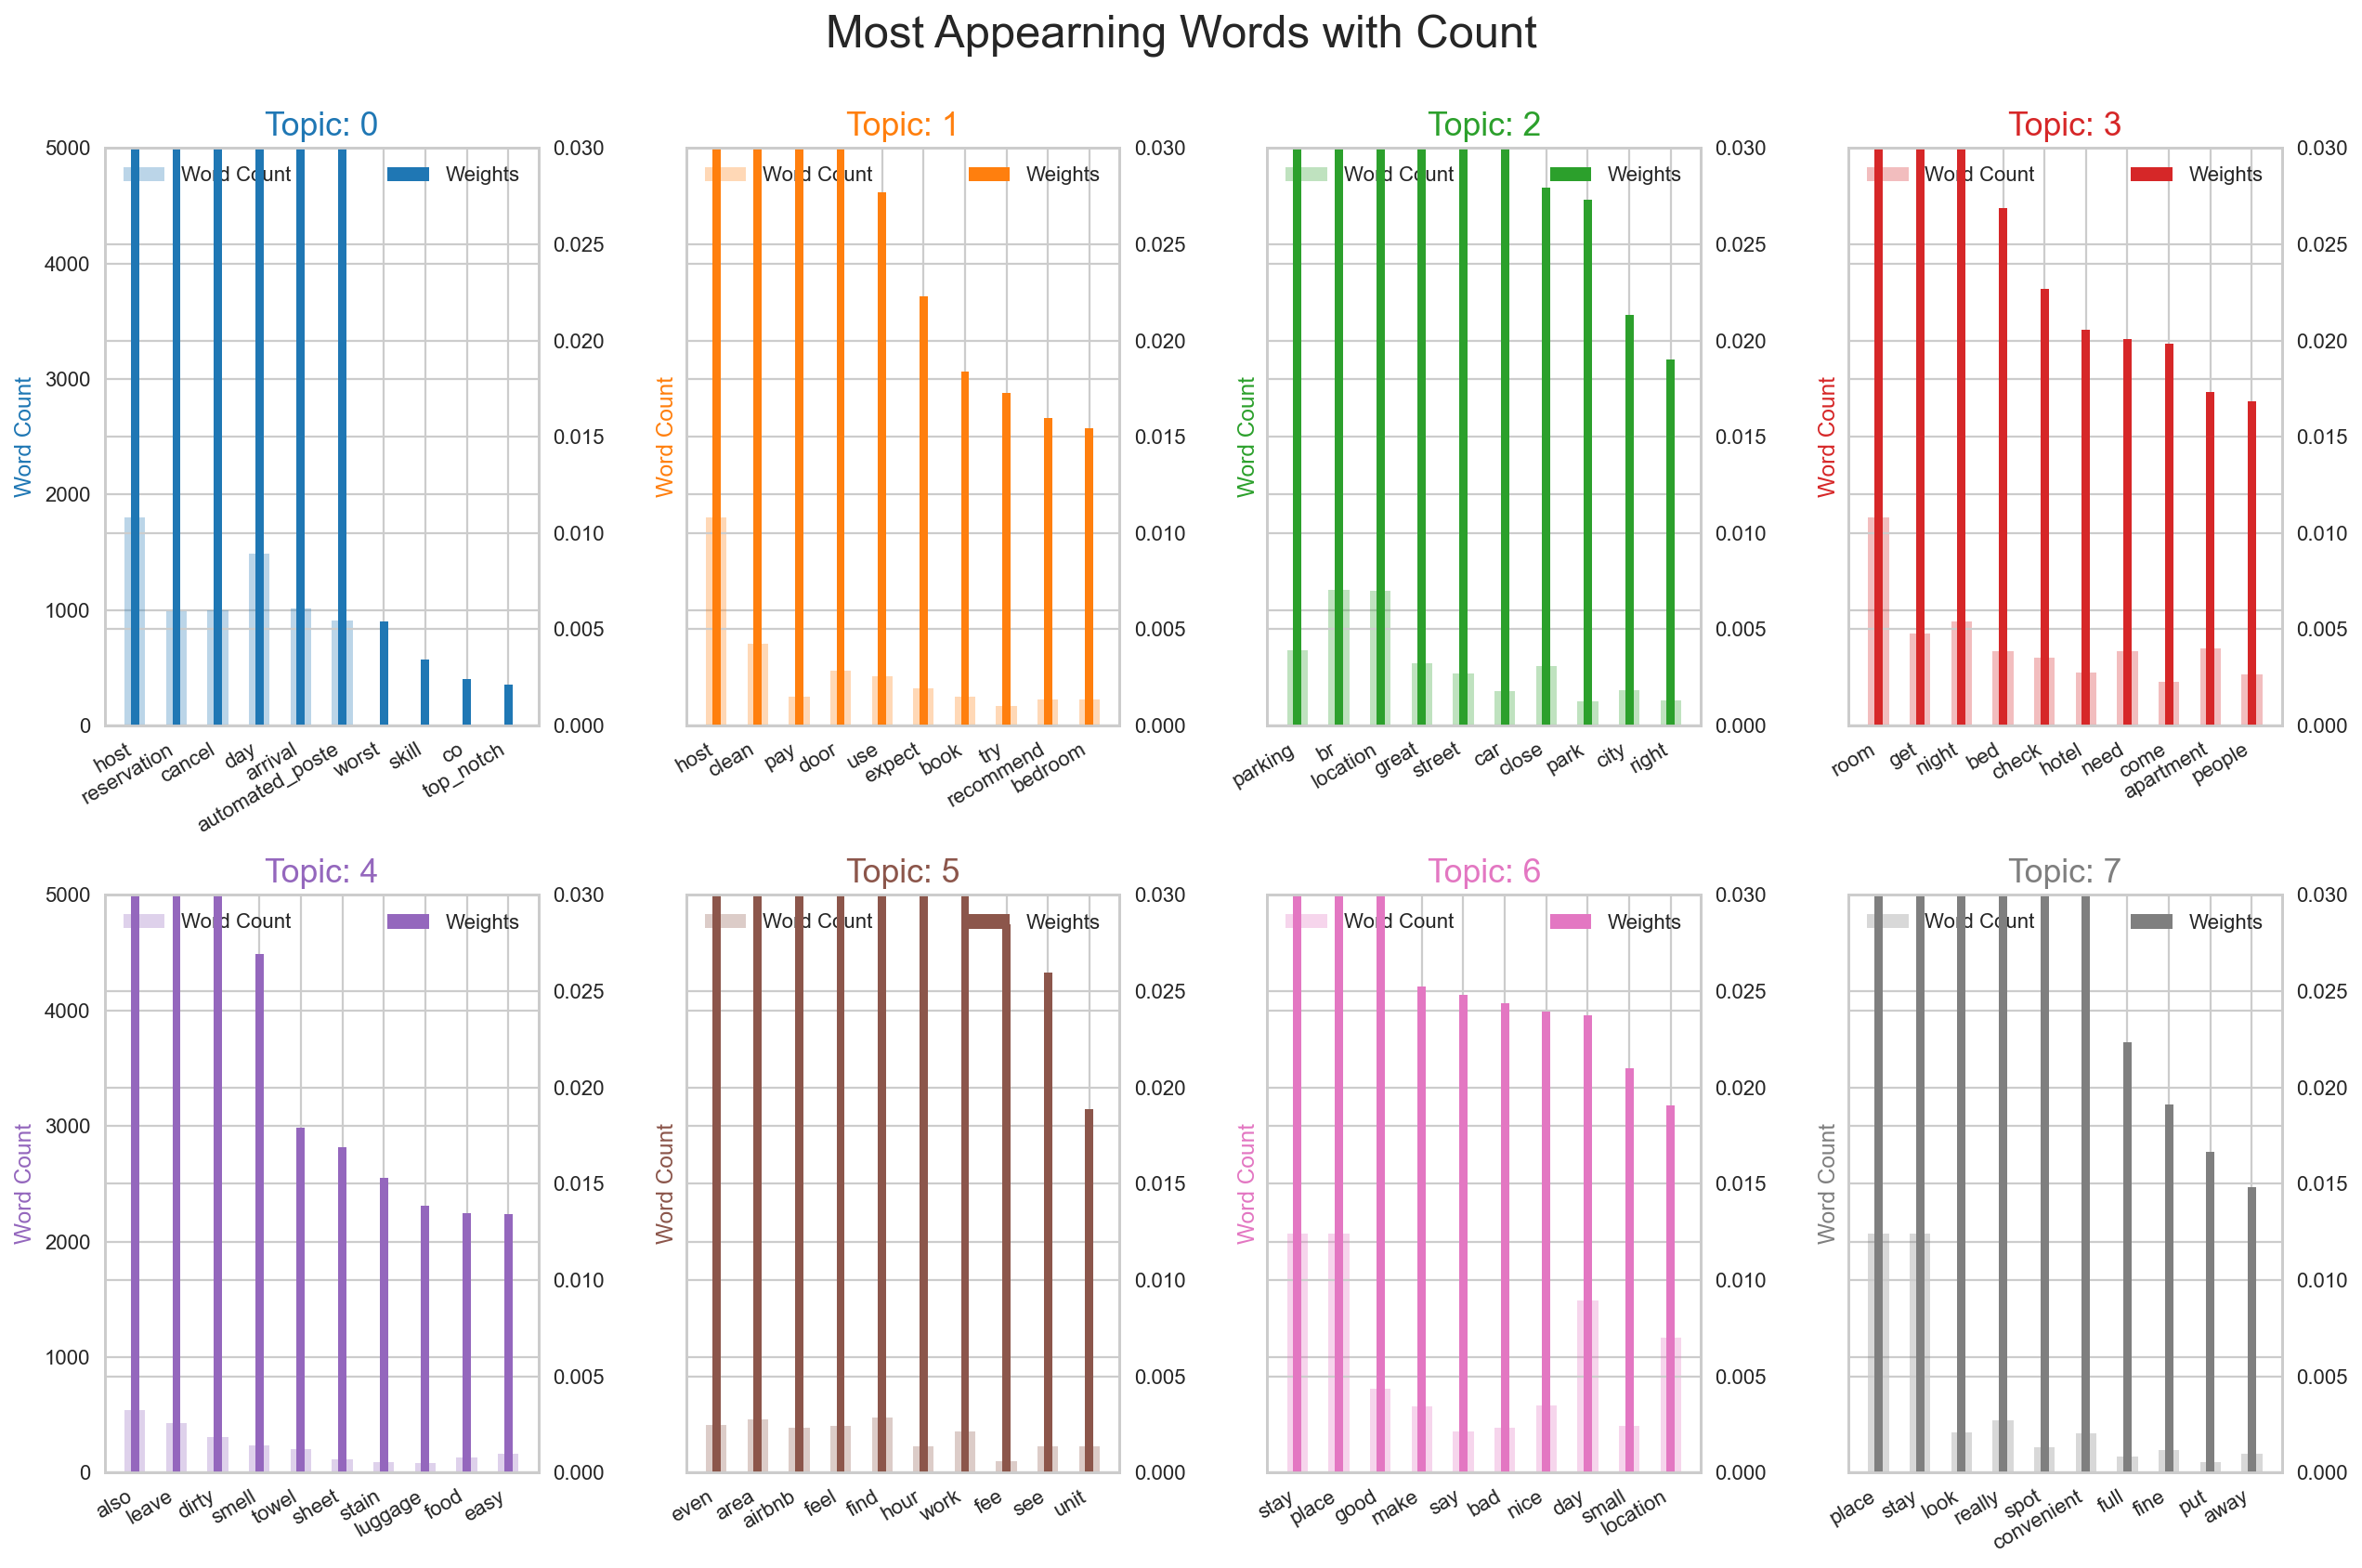

In [24]:
fig, axes = plt.subplots(2, 4, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data = df_f.loc[df_f.topic_n==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    
    ax_twin.bar(x='word', height="most_appear", data = df_f.loc[df_f.topic_n==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 5000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    
    ax.set_xticklabels(df_f.loc[df_f.topic_n==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Most Appearning Words with Count', fontsize=22, y=1.05)   

plt.show()

## Words by Topic WordCloud

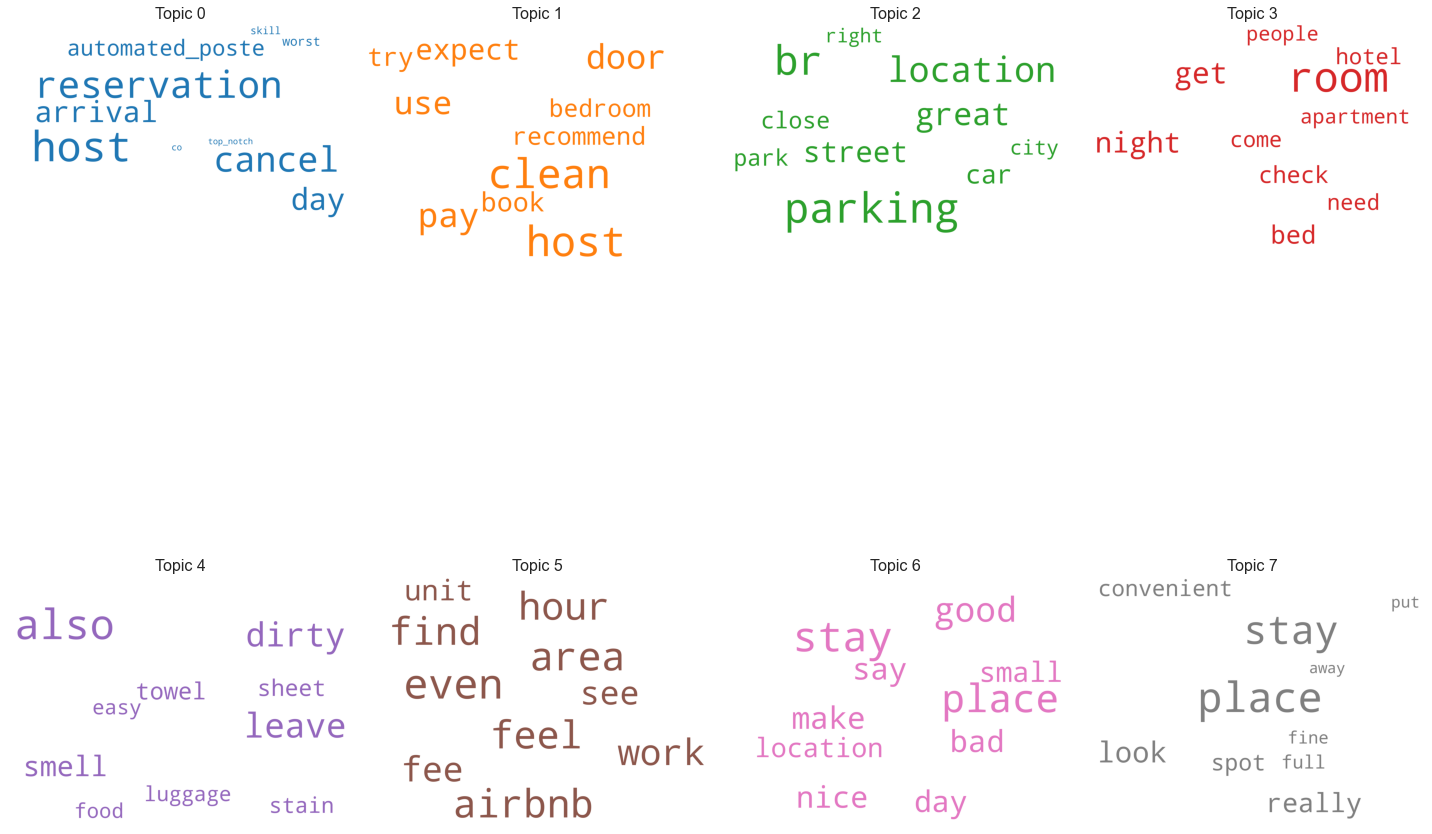

In [25]:
colors2 = [color for name, color in mcolors.TABLEAU_COLORS.items()] 

topic_clouds = WordCloud(stopwords=stop_words,background_color='white', width=2500,height=1800, max_words=25, colormap='tab10',
                  color_func=lambda *args, **kwargs: colors2[i],prefer_horizontal=1.0)


fig, axes = plt.subplots(2, 4, figsize=(20,20), sharex=True, sharey=True)
 

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    
    topic_words = dict(topics[i][1])
    topic_clouds.generate_from_frequencies(topic_words, max_font_size=300)
    
    plt.gca().imshow(topic_clouds)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

##  NMF run using 3 topics

In [26]:

nmf = NMF(n_components=3)

nmf.fit(docs)

NMF(n_components=3)

In [27]:
topic_matrix = nmf.transform(docs)

In [28]:
topic_matrix_df = pd.DataFrame(topic_matrix).add_prefix('topic_')

topic_matrix_df['comments'] = df['comments']
topic_matrix_df.head()

,topic_0,topic_1,topic_2,comments
0,0.000000,0.000000,0.306998,The host canceled this reservation 12 days bef...
1,0.000000,0.000000,0.000000,.
2,0.000000,0.120643,0.000000,"If you want to fell the concept "" Being home ..."
3,0.000223,0.018834,0.000000,"On a very quiet residential street, but close ..."
4,0.000862,0.004818,0.001514,10/10


In [29]:
word_topic_matrix_df = pd.DataFrame(nmf.components_, columns=features).T.add_prefix('topic_')
word_topic_matrix_df.head()

,topic_0,topic_1,topic_2
00,0.007856,0.069683,0.000452
000,0.001563,0.006426,0.001006
0000,0.003309,0.000000,0.000000
00am,0.003936,0.000024,0.000000
00pm,0.001813,0.016648,0.000000


## Read Samples from Topic 0 

In [30]:
for review in topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)['comments'].values:
    print(review)
    print()

Air Bnb<br/><br/>Will NEVER stay in an Air Bnb again. <br/><br/>The ad reports that there are surveillance devices “on” the property. It does not indicate that they are IN the property. Also, there are no instructions provided on how to lock the door. If you read through the messages with Fa, she says to press in the code to open the door and the “Schlage” button to lock the door. When inside, the “Schlage” button DOES NOT lock the door. The door has to be manually locked from inside. The door was left open all night, completely accessible and unprotected from the outside <br/><br/>The both shelves inside the shower are rusted. The garbage is left IN THE MIDDLE OF THE FLOOR in the kitchen. If you want to eat, it is within 5 feet of an UNCOVERED garbage bag. Garbage is not even inside of a pail or container, it is in cardboard boxes and bags. I have photos of both. There were two lamps in the room. One did not have a light bulb. I took pictures to prove all of the above. <br/><br/>It wa

## Read Samples from Topic 1 


In [31]:
for review in topic_matrix_df.sort_values(by='topic_1', ascending=False).head(5)['comments'].values:
    print(review)
    print()

Not the ‘peace hostel’ experience I was expecting. Despite the very impersonal check in system, with codes on doors which can be guessed with an IQ of 70, there were actually two members of staff on site for my 5 night stay. Both of whom were rude, one in particular who was badmouthing me and my friends in front of and behind our backs, after we asked for some assistance with their room. My room was aptly named the sunshine room as the curtains are so thin the sun comes through in the morning interrupting my sleep, but other than that the room didn’t not fit the description. It was dirty, my bed wasn’t properly made, the towels were stained and the rug on the floor was so filthy I didn’t take my socks off once. This is a hostel, but a very expensive hostel, and Despite someone coming in daily to ‘make’ your bed by smoothing the sheet and delivering more ‘clean’ towels, there were no other perks to warrant the cost of this place per night. It cost me £125 per night plus a cleaning fee(!

## Read Samples from Topic 2


In [32]:
for review in topic_matrix_df.sort_values(by='topic_2', ascending=False).head(5)['comments'].values:
    print(review)
    print()

The host canceled this reservation 11 days before arrival. This is an automated posting.

The host canceled this reservation 11 days before arrival. This is an automated posting.

The host canceled this reservation 11 days before arrival. This is an automated posting.

The host canceled this reservation 11 days before arrival. This is an automated posting.

The host canceled this reservation 11 days before arrival. This is an automated posting.



# Top 10 Words from Each Topic

In [33]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [34]:
display_topics(nmf, features, 10)


Topic  0
br, airbnb, door, kitchen, apartment, house, did, unit, host, left

Topic  1
room, place, stay, night, location, clean, did, just, apartment, host

Topic  2
host, arrival, reservation, canceled, posting, automated, days, day, 11, 17


In [35]:
word_topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)

,topic_0,topic_1,topic_2
br,12.432344,0.000000,0.000000
airbnb,0.472139,1.139916,0.073874
door,0.425726,1.282965,0.000000
kitchen,0.369525,0.783163,0.000000
apartment,0.355005,1.335026,0.027638
house,0.347407,1.312116,0.014092
did,0.345667,1.370607,0.054554
unit,0.334537,0.429597,0.038352
host,0.319715,1.319251,3.643991
left,0.319572,0.580584,0.028919


In [36]:
word_topic_matrix_df.sort_values(by='topic_1', ascending=False).head(10)

,topic_0,topic_1,topic_2
room,0.221660,4.333374,0.000000
place,0.000000,4.108207,0.000000
stay,0.136157,3.302218,0.009315
night,0.289490,2.095568,0.000000
location,0.138927,1.572421,0.000000
clean,0.149873,1.373578,0.000000
did,0.345667,1.370607,0.054554
just,0.041426,1.340739,0.000000
apartment,0.355005,1.335026,0.027638
host,0.319715,1.319251,3.643991


In [37]:
word_topic_matrix_df.sort_values(by='topic_2', ascending=False).head(10)

,topic_0,topic_1,topic_2
host,0.319715,1.319251,3.643991
arrival,0.004943,0.000000,3.249911
reservation,0.000000,0.000000,3.246213
canceled,0.000000,0.000000,3.168618
posting,0.000000,0.000000,3.162024
automated,0.000000,0.000000,3.160364
days,0.093828,0.042362,3.135837
day,0.252370,1.111337,0.152274
11,0.004950,0.050386,0.089131
17,0.000000,0.006853,0.081896


In [38]:
def top_reviews(topic_matrix_df, topic, num_of_reviews):
    return (topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(num_of_reviews)['comments']
            .values)

def top_words(word_topic_matrix_df, topic, n_of_words):
    return (word_topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(n_of_words))[topic]

In [39]:
for review in top_reviews(topic_matrix_df, 'topic_0', 5):
    print(review)
    print()

Air Bnb<br/><br/>Will NEVER stay in an Air Bnb again. <br/><br/>The ad reports that there are surveillance devices “on” the property. It does not indicate that they are IN the property. Also, there are no instructions provided on how to lock the door. If you read through the messages with Fa, she says to press in the code to open the door and the “Schlage” button to lock the door. When inside, the “Schlage” button DOES NOT lock the door. The door has to be manually locked from inside. The door was left open all night, completely accessible and unprotected from the outside <br/><br/>The both shelves inside the shower are rusted. The garbage is left IN THE MIDDLE OF THE FLOOR in the kitchen. If you want to eat, it is within 5 feet of an UNCOVERED garbage bag. Garbage is not even inside of a pail or container, it is in cardboard boxes and bags. I have photos of both. There were two lamps in the room. One did not have a light bulb. I took pictures to prove all of the above. <br/><br/>It wa

In [40]:
top_words(word_topic_matrix_df, 'topic_0', 10)

br           12.432344
airbnb        0.472139
door          0.425726
kitchen       0.369525
apartment     0.355005
house         0.347407
did           0.345667
unit          0.334537
host          0.319715
left          0.319572
Name: topic_0, dtype: float64

In [41]:
for review in top_reviews(topic_matrix_df, 'topic_1', 5):
    print(review)
    print()

Not the ‘peace hostel’ experience I was expecting. Despite the very impersonal check in system, with codes on doors which can be guessed with an IQ of 70, there were actually two members of staff on site for my 5 night stay. Both of whom were rude, one in particular who was badmouthing me and my friends in front of and behind our backs, after we asked for some assistance with their room. My room was aptly named the sunshine room as the curtains are so thin the sun comes through in the morning interrupting my sleep, but other than that the room didn’t not fit the description. It was dirty, my bed wasn’t properly made, the towels were stained and the rug on the floor was so filthy I didn’t take my socks off once. This is a hostel, but a very expensive hostel, and Despite someone coming in daily to ‘make’ your bed by smoothing the sheet and delivering more ‘clean’ towels, there were no other perks to warrant the cost of this place per night. It cost me £125 per night plus a cleaning fee(!

In [42]:
top_words(word_topic_matrix_df, 'topic_1', 10)

room         4.333374
place        4.108207
stay         3.302218
night        2.095568
location     1.572421
clean        1.373578
did          1.370607
just         1.340739
apartment    1.335026
host         1.319251
Name: topic_1, dtype: float64

In [43]:
for review in top_reviews(topic_matrix_df, 'topic_2', 5):
    print(review)
    print()

The host canceled this reservation 11 days before arrival. This is an automated posting.

The host canceled this reservation 11 days before arrival. This is an automated posting.

The host canceled this reservation 11 days before arrival. This is an automated posting.

The host canceled this reservation 11 days before arrival. This is an automated posting.

The host canceled this reservation 11 days before arrival. This is an automated posting.



In [44]:
top_words(word_topic_matrix_df, 'topic_2', 10)

host           3.643991
arrival        3.249911
reservation    3.246213
canceled       3.168618
posting        3.162024
automated      3.160364
days           3.135837
day            0.152274
11             0.089131
17             0.081896
Name: topic_2, dtype: float64

In [45]:
t1 = top_words(word_topic_matrix_df, 'topic_0', 100)
t1_10 = top_words(word_topic_matrix_df, 'topic_0', 10)

In [46]:
tl_dict = t1.to_dict()

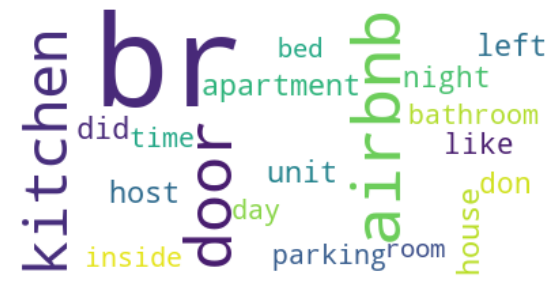

In [47]:
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(tl_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic1')
plt.show()


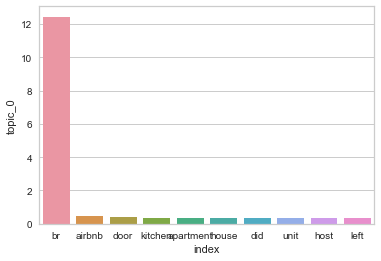

In [48]:
l_df = t1_10.to_frame()
l_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_0', data=l_df);

In [49]:
second_top = top_words(word_topic_matrix_df, 'topic_1', 100)
t2_10 = top_words(word_topic_matrix_df, 'topic_1', 10)

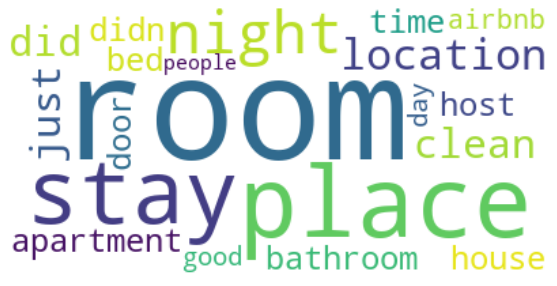

In [50]:
second_top_dict = second_top.to_dict()
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(second_top_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic2')
plt.show()


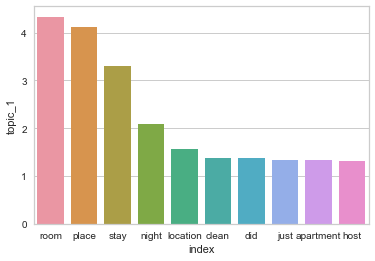

In [51]:
t2_df = t2_10.to_frame()
t2_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_1', data=t2_df);

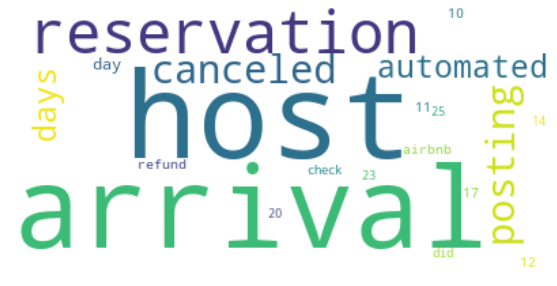

In [52]:
third_top = top_words(word_topic_matrix_df, 'topic_2', 100)
t3_10 = top_words(word_topic_matrix_df, 'topic_2', 10)


third_top_dict = third_top.to_dict()
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(third_top_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic3')
plt.show()

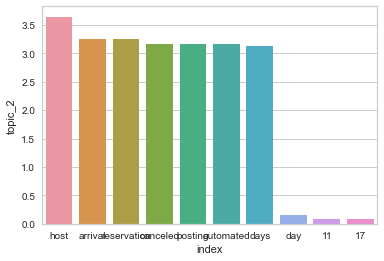

In [53]:
t3_df = t3_10.to_frame()
t3_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_2', data=t3_df);

## Build The LDA model With 5 Topics

In [54]:
lda_model_5 = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=doc_dict,num_topics=5, random_state=33,
                                           update_every=1,chunksize=15,passes=10,alpha='symmetric',iterations=100,
                                           per_word_topics=True)

pprint(lda_model_5.print_topics())

[(0,
  '0.053*"place" + 0.053*"location" + 0.033*"good" + 0.032*"clean" + '
  '0.028*"check" + 0.025*"bad" + 0.021*"apartment" + 0.020*"lot" + '
  '0.017*"guest" + 0.016*"walk"'),
 (1,
  '0.169*"host" + 0.113*"day" + 0.070*"airbnb" + 0.060*"work" + '
  '0.038*"reservation" + 0.035*"first" + 0.033*"cancel" + 0.023*"think" + '
  '0.022*"hard" + 0.022*"arrival"'),
 (2,
  '0.042*"stay" + 0.030*"parking" + 0.029*"br" + 0.024*"place" + 0.016*"find" '
  '+ 0.016*"say" + 0.015*"nice" + 0.014*"street" + 0.014*"even" + '
  '0.012*"area"'),
 (3,
  '0.077*"room" + 0.030*"night" + 0.023*"bed" + 0.019*"great" + 0.018*"hotel" '
  '+ 0.018*"stay" + 0.017*"come" + 0.016*"also" + 0.015*"get" + '
  '0.015*"people"'),
 (4,
  '0.031*"need" + 0.031*"get" + 0.027*"pay" + 0.027*"door" + 0.020*"expect" + '
  '0.019*"fee" + 0.016*"book" + 0.015*"well" + 0.014*"recommend" + '
  '0.013*"call"')]


## List of words by topic

In [55]:
topics_5 = lda_model_5.show_topics(formatted=False)

In [56]:
type(topics_5)

list

In [57]:
topics_5

[(0,
  [('place', 0.05324255),
   ('location', 0.053206645),
   ('good', 0.032834336),
   ('clean', 0.03222792),
   ('check', 0.027539188),
   ('bad', 0.024959605),
   ('apartment', 0.021039689),
   ('lot', 0.020430287),
   ('guest', 0.017058128),
   ('walk', 0.015958091)]),
 (1,
  [('host', 0.16900222),
   ('day', 0.112860866),
   ('airbnb', 0.069872394),
   ('work', 0.060164005),
   ('reservation', 0.03759343),
   ('first', 0.035489958),
   ('cancel', 0.032524176),
   ('think', 0.02284069),
   ('hard', 0.022191986),
   ('arrival', 0.022047747)]),
 (2,
  [('stay', 0.042241327),
   ('parking', 0.030331649),
   ('br', 0.028737828),
   ('place', 0.023703171),
   ('find', 0.016022842),
   ('say', 0.015868396),
   ('nice', 0.015296271),
   ('street', 0.014135229),
   ('even', 0.013626807),
   ('area', 0.012416832)]),
 (3,
  [('room', 0.07650591),
   ('night', 0.030192366),
   ('bed', 0.02320494),
   ('great', 0.019175222),
   ('hotel', 0.01774404),
   ('stay', 0.017712526),
   ('come', 0.0